100%|██████████| 493/493 [00:00<00:00, 1436.99it/s]


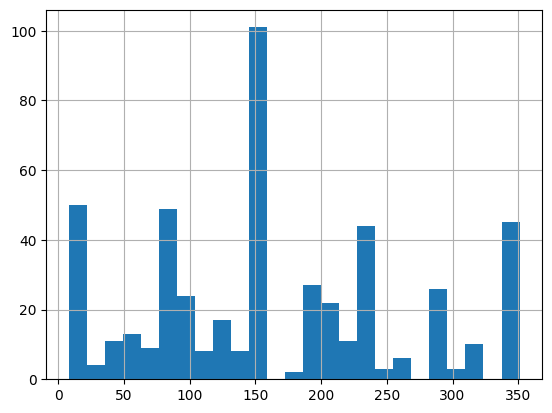

In [1]:
import pandas as pd
import datetime

from mandrill.dataset import read_dataset, MandrillTripleImageDataset, MandrillImageDataset, filter_by_qty

max_age = 1
max_days = 365 * max_age

dataset_path = "../data/db2/MFD_metadatas.csv"

data = read_dataset(dataset_path, filter_dob_error=False, filter_certainty=True, max_age=max_days, max_dob_error=10)
hist = data["age"].hist(bins=25)

dataset = MandrillImageDataset(root_dir='../data/db2/Images/', dataframe=data, in_mem=True, max_days=max_days)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import cv2
import os
from tqdm import tqdm

from mandrill.models import InceptionResnetV1, RegressionModel, VGGFace
from mandrill.utils import split_dataset, load, save

learning_rate = 1e-4
batch_size = 64
num_epochs = 100
train_ratio = 0.8
val_ratio = 0.2

torch.manual_seed(0)
train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size, augment=False)

# Model
# backbone = InceptionResnetV1()
backbone = VGGFace(start_filters=16)
model = RegressionModel(backbone, input_dim=backbone.output_dim, lin_start=2048, n_lin=6)

# Loss function
criterion = nn.MSELoss()
val_criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
backbone = backbone.to(device)
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = val_criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    
    # Print training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val L1: {val_loss:.4f}")

Using device: cuda


100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch [1/100] - Train Loss: 0.0732 - Val L1: 0.2236


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch [2/100] - Train Loss: 0.0704 - Val L1: 0.2219


100%|██████████| 2/2 [00:00<00:00,  7.96it/s]


Epoch [3/100] - Train Loss: 0.0563 - Val L1: 0.2254


100%|██████████| 2/2 [00:00<00:00,  7.83it/s]


Epoch [4/100] - Train Loss: 0.0397 - Val L1: 0.2870


100%|██████████| 2/2 [00:00<00:00,  7.98it/s]


Epoch [5/100] - Train Loss: 0.0294 - Val L1: 0.2253


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from mandrill.utils import load

# model = load(model, "vgg_face", exp_name="exp1_regression")

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

max_display = 10

age_errors = []
age_truth = []
age_predicted = []

model.eval()

# Perform inference on validation images
for i, (images, targets) in enumerate(val_loader):
    # Forward pass
    images = images.to(device)
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    predicted_values = outputs.squeeze().detach().cpu().numpy() * 365
    actual_values = targets.squeeze().cpu().numpy() * 365
    
    age_errors.append(predicted_values - actual_values)
    age_truth.append(actual_values)
    age_predicted.append(predicted_values)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted Values:", predicted_values)
    print("Actual Values:", actual_values)
    print("Prediction Error: ", predicted_values - actual_values)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {predicted_values}, Actual: {actual_values}")
    plt.show()

age_errors = np.array(age_errors)
print("Absolute age error (in days): ", np.mean(age_errors), " std: ", np.std(age_errors))

In [ ]:
# Histogram with x being the real age and y being the error on this age
# Plotting the histogram

def group_by(x, n_bins):
    step = np.max(x) / n_bins
    x = np.array(x)
    for i in range(n_bins+1):
        nx = i*step
        px = max(0, (i-1)*step)
        x[np.logical_and(x <= nx, x > px)] = nx
    x[np.logical_and(x <= np.max(x), x > (n_bins*step))] = np.max(x)
    return x.tolist()

def bin_errors(x, y):
    bins = np.unique(x)
    y_mean = []
    y_err = []
    y = np.array(y)
    for b in bins:
        y_bin = y[x == b]
        y_mean.append(np.mean(y_bin))
        y_err.append(np.std(y_bin))
    return np.array(y_mean), np.array(y_err)

n_bins = 12

x = age_truth
y = age_errors

sorted_lists = sorted(zip(x, y))
sorted_x, sorted_y = zip(*sorted_lists)

def display_error_curve(x, y, n_bins):
    x = group_by(x, n_bins)
    y, y_err = bin_errors(x, y)
    x = np.unique(x)

    plt.plot(x, y, 'k-', label='Prediction error')
    plt.fill_between(x, y-y_err, y+y_err)
    plt.show()

display_error_curve(sorted_x, sorted_y, n_bins)
display_error_curve(sorted_x, abs(np.array(sorted_y)), n_bins)

# Age validation distribution
age_data = pd.DataFrame(data={"age": x})
age_data["age"].hist(bins=n_bins)

In [ ]:
#from mandrill.utils import save
#name="exp1_regression"
#save(model, "vgg_face", exp_name=name)
#print("saved")